# Multi-modal GCN for edge prediction

In this tutorial, we will show you how to use a Graph Convolutional Network (GCN) to make predictions about the edges in a graph. The GCN we will use in this tutorial is a Kipf GCN, which uses a symmetrically normalized Laplacian matrix to define the convolution operation.

We will use the MONDO ontology as the input graph for our GCN. MONDO is a disease ontology that aims to harmonize disease definitions across the world. The graph will be preprocessed and the input features will include node types, node descriptions, and topological embedding using the DeepWalk model. We will also use a BERT-based model to generate BM25-weighted embeddings for the node descriptions.

After preprocessing the graph and generating the input features, we will show you how to train and evaluate the Kipf GCN on the edge prediction task. We will also discuss some of the advantages and limitations of using a GCN for this type of problem and provide some suggestions for further study.

Overall, this tutorial will provide a detailed and hands-on guide to using a GCN for edge prediction on a graph-structured dataset. It will demonstrate the use of a variety of input features to improve the performance of the GCN, as well as the importance of preprocessing the input data and selecting an appropriate GCN model.

![Multi-modal Kipf GCN](https://github.com/AnacletoLAB/grape/blob/main/images/multi-modal%20KG%20GCN%20for%20edge%20prediction.png?raw=true)


## What is a GCN? 
A GCN (Graph Convolutional Network) is a type of neural network that is designed to operate on graph-structured data, such as social networks or molecular structures. A Kipf GCN is a specific type of GCN that uses a symmetrically normalized Laplacian matrix to define the convolution operation. In this tutorial, we will use a Kipf GCN to make predictions about the edges in a graph.

## What are BM25-weighted BERT-based embedding?
BERT (Bidirectional Encoder Representations from Transformers) is a type of transformer-based language model that has been trained on a large corpus of text data. It can be used to generate embeddings for words or sentences in a text, which can then be used as input to a machine learning model. In this tutorial, we will use a BERT-based model to generate embeddings for the node descriptions in our graph.

BM25 is a ranking function used in information retrieval to score the relevance of documents based on a user's query. It is commonly used in search engines to rank the results of a search query.

BM25-weighted BERT-based embedding is a technique for generating numerical representations of the content of a text, such as a document or a sentence. The idea is to first use the BM25 ranking function to weight the importance of each word in the text based on a user's query. Then, a BERT-based model is used to generate embeddings for the words in the text, which capture the relationships between the words in a low-dimensional space. The resulting embeddings are then weighted by the BM25 scores to give more importance to the words that are more relevant to the query. This technique can be used as input to a machine learning model, such as a GCN, to capture the semantic content of the text.

## What is MONDO?
The Mondo Disease Ontology (Mondo) aims to harmonize disease definitions across the world. In this tutorial, we will use the MONDO ontology as the graph on which our GCN will operate.

### What are node types in MONDO?
A node type is a category or class of nodes in a graph. For example, in the MONDO ontology, some of the node types might include "Disease" or "Cell". In this tutorial, we will use the node types as input to our GCN, which will allow the model to capture the relationships between nodes and their corresponding types.


## What is Biolink?
Biolink is a standardized vocabulary for representing biological entities and their relationships. It includes a set of descriptions, which we can convert into text-based embeddings, which are numerical representations of the relationships between words in a text. These embeddings can be used as input features for machine learning models, such as a GCN.

## Topological embedding and DeepWalk
Topological embedding is a technique for representing the structure of a graph in a low-dimensional space. The idea is to preserve the relationships between nodes in the graph, such as which nodes are connected to each other, in the embedded space. One popular method for topological embedding is DeepWalk, which uses a random walk to generate a sequence of nodes in the graph and then uses a language model to learn the embeddings of the nodes. In this tutorial, we will use DeepWalk to generate topological embeddings for the nodes in our graph.

Topological embedding are a meaningful import to GCNs as the provide global topological features that a GCN may not be able to compute, expecially on graphs with a large diameter.

## Let's get started!

Great! Now that you have a basic understanding of the concepts and tools that we will be using in this tutorial, let's get started. In the next few sections, we will show you how to load and preprocess the graph, retrieve the input features, and implement the Kipf GCN model. We will also demonstrate how to make predictions on unseen data. So let's dive in and see how we can use a GCN to make edge predictions on the MONDO ontology.

In [1]:
# We import Silence TensorFlow because we want to
# remove the extra-verbose logs of TensorFlow
import silence_tensorflow.auto

### Loading the MONDO ontology

This code imports the MONDO ontology from the grape's graph retrieval tool and loads it into memory. It then picks a specific version of the graph and downloads it. Next, it keeps only the largest component of the graph, dropping any nodes that are not connected to any other nodes, and enables the fastest data structure for the graph to improve performance. This prepares the graph for further processing and analysis.

In [2]:
%%time

# We import the graph from grape's graph retrieval
# but you can load a custom one from a CSV!
from grape.datasets.kgobo import MONDO

# We pick a version of the graph
version = "2022-11-01"
# Download and load the graph
graph = MONDO(version=version)
# Keep only the largest component of the graph, dropping singletons
graph_main_component = graph.remove_components(top_k_components=1)
# We enable the fastest data structure for the graph
graph_main_component.enable()

CPU times: user 3.71 s, sys: 876 ms, total: 4.59 s
Wall time: 5.58 s


## Retrieving Biolink BM25-weighted Specter embedding
In this section, we show how to easily retrieve the Specter embedding from the biolink embedding repository. The Specter embedding is a numerical representation of the relationships between the words in a text, which can be used as input to a machine learning model. We use the pandas library to read the embedding from the repository and store it in a dataframe. The embedding is then filtered to include only the node types of interest in the MONDO ontology. The resulting embedding can be used as input to our GCN model to capture the semantic content of the node types in the graph.

We can easily retrieve the Specter embedding from [the biolink embedding repository](https://github.com/LucaCappelletti94/biolink_embedding) using the following one-liner.

Do note that there are also BERT and SciBERT embeddings ready, and you can easily create more with other methods.

In [3]:
import pandas as pd

biolink_specter = pd.read_csv(
    "https://github.com/LucaCappelletti94/biolink_embedding/blob/main/biolink_3.1.1_allenai_specter.csv.gz?raw=true",
    compression='gzip',
    index_col=[0]
)
biolink_specter

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
category,,,,,,,,,,,,,,,,,,,,,
model organism database,-0.003704,0.009470,0.005300,-0.007590,-0.003817,-0.011604,0.010710,-0.004936,-0.001653,0.004894,...,-0.005283,0.001886,0.005943,-0.006687,0.001750,-0.003757,-0.013320,0.005104,0.009995,0.003765
translator minimal,-0.042420,0.001458,-0.025270,-0.004700,-0.012590,-0.033260,-0.025270,-0.035900,-0.029820,-0.044530,...,0.043060,0.034270,-0.018620,-0.013450,-0.029700,-0.035580,-0.039400,-0.030790,-0.004090,-0.033700
samples,-0.019130,0.039370,0.062320,0.001011,-0.029630,-0.038820,0.018220,-0.024840,0.008575,0.003899,...,-0.000366,-0.051420,-0.090000,0.000275,-0.078200,-0.002556,0.009030,-0.000885,-0.029680,0.048340
testing,-0.084500,0.002682,-0.069950,0.021580,-0.028210,-0.052900,0.054530,-0.008310,0.072600,-0.015430,...,0.021360,-0.026700,-0.057220,-0.107400,-0.136700,0.103800,0.115000,-0.020840,0.040700,0.102970
chemical formula value,-0.023470,-0.070560,-0.046970,0.023530,-0.026580,0.078370,-0.041960,0.011550,-0.070900,-0.086300,...,-0.030800,-0.047760,-0.020580,-0.011940,0.021700,-0.043330,-0.083600,-0.015114,0.109300,0.067400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
organism taxon to entity association,-0.012330,-0.006440,-0.006260,0.008640,-0.004436,-0.002990,-0.003178,-0.006250,0.014860,-0.000189,...,-0.008880,-0.001175,-0.007683,-0.008766,0.000989,-0.015434,-0.006360,0.004147,0.019470,0.000651
organism taxon to organism taxon association,-0.016850,-0.013080,-0.005592,0.008934,-0.004684,-0.006634,-0.004677,-0.011150,0.010956,-0.002607,...,-0.014970,0.001061,-0.015210,-0.014915,0.000927,-0.024030,-0.005840,0.003853,0.023620,-0.001053
organism taxon to organism taxon specialization,-0.001431,-0.004690,-0.002348,0.001380,-0.000289,-0.004130,-0.001797,-0.002909,0.003860,-0.002785,...,-0.003168,-0.002039,-0.001951,-0.002817,-0.003515,-0.004757,-0.000901,-0.000500,0.002770,-0.000510


In this code, we use the pandas library to filter the biolink Specter embedding that we retrieved in the previous section. We only keep the embedding for the node types that are present in the MONDO ontology. This is accomplished using a regular expression to match the node type names in the ontology with the names in the embedding. The resulting node type features can then be used as input to our GCN model to capture the semantic content of the node types in the graph.

In [4]:
import re

node_type_features = pd.DataFrame(
    biolink_specter.loc[[
        re.sub(r"(\w)([A-Z])", r"\1 \2", node_type_name.split(":")[1]).lower()
        for node_type_name in graph_main_component.get_unique_node_type_names()
    ]].values,
    index=graph_main_component.get_unique_node_type_names()
)

node_type_features

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
biolink:Disease,-0.000925,-0.000639,-0.000246,-0.000431,-0.000392,0.000520,0.000349,0.000544,0.000163,0.000055,...,-0.000210,-0.000139,-0.000150,-0.000787,-0.000222,-0.000040,0.000176,-0.000119,0.001266,-0.000106
biolink:PhenotypicFeature,-0.000815,0.000866,-0.000799,0.000046,-0.001486,0.001362,-0.000258,0.000434,0.000435,0.000504,...,-0.000010,-0.000259,-0.001770,0.000165,-0.000346,-0.000176,-0.000702,-0.000687,0.001119,-0.000722
biolink:AnatomicalEntity,-0.021510,-0.001241,-0.007990,-0.010666,-0.006893,-0.010445,-0.002703,-0.008960,0.013640,0.005600,...,-0.003550,-0.007860,-0.017400,-0.012940,-0.013336,0.005077,-0.002403,0.024830,0.015850,-0.013664
biolink:OrganismalEntity,-0.005413,0.000614,0.001161,0.002400,-0.002780,-0.001842,-0.000555,-0.000452,0.001820,0.001537,...,0.000330,0.001341,-0.003730,-0.003191,-0.002583,-0.002820,-0.004204,-0.000036,0.005917,-0.002285
biolink:NamedThing,-0.025680,0.010796,0.000980,-0.000294,-0.009530,-0.005306,-0.006134,-0.006360,0.005665,0.005783,...,-0.008575,0.007786,-0.015550,-0.016630,0.002570,-0.011660,-0.009320,0.014730,0.018780,-0.004807
biolink:ChemicalSubstance,-0.001032,-0.000130,-0.000294,-0.000248,0.000088,0.000105,0.000225,-0.000205,-0.000740,0.000172,...,-0.000203,-0.000319,-0.000085,0.000025,-0.000273,-0.000197,-0.000667,-0.000487,0.000482,-0.000586
biolink:SequenceFeature,-0.001911,-0.001709,-0.001085,0.000548,-0.000582,0.000231,-0.001022,0.000441,-0.000084,0.000922,...,-0.000379,-0.000079,0.000123,0.000354,-0.000804,-0.000502,-0.000044,0.000194,0.000363,-0.000800
biolink:Cell,-0.155800,-0.150600,-0.126800,0.113700,-0.111200,-0.015670,0.013590,-0.255900,0.177200,0.034850,...,0.091250,-0.216100,-0.342500,0.001437,-0.178700,0.221700,0.102600,0.232500,-0.243000,-0.204600


The resulting dataframe contains a set of node type features that have been extracted from the biolink Specter embedding. Each row in the dataframe represents a node type, and each column represents a feature of the node type. These features capture the semantic content of the node types and can be used as input to a machine learning model. The values in the cells of the dataframe represent the numerical values of the features.

## Node descriptions BM25-weighted Specter embedding

The following code uses the GRAPE library to compute a BM25-weighted Specter embedding for the node descriptions in the MONDO disease ontology. This embedding is based on the Specter natural language processing pre-trained model and is computed using the Okapi BM25 ranking method. The resulting embedding can be used in a variety of applications, such as text-based search and retrieval, natural language processing, and machine learning. The code also filters the embedding to only include nodes from the graph's main component. This step helps to ensure that the embedding is more accurate and relevant for the given graph.

We can use GRAPE's nifty one-liner to easily compute BM25-weighted Specter embedding for the node descriptions `get_kgobo_okapi_tfidf_weighted_textual_embedding`.

Do note that any BERT-based model is readily supported, and we can easily support other NLP models.

In [5]:
%%time
# We load the tool to compute BM25-weighted
# BERT embedding of the nodes description
from grape.datasets import get_kgobo_okapi_tfidf_weighted_textual_embedding

# And we compute a SciBERT embedding for the
#captions associated to the graph nodes
node_descriptions_embedding = pd.DataFrame(
    get_kgobo_okapi_tfidf_weighted_textual_embedding(
        name=graph.get_name(),
        version=version,
        columns=["id", "category", "name", "description", "provided_by"],
        pretrained_model_name_or_path="allenai/specter",
    ),
    index=graph.get_node_names()
).loc[graph_main_component.get_node_names()]
node_descriptions_embedding

CPU times: user 109 ms, sys: 83.5 ms, total: 192 ms
Wall time: 192 ms


,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
MONDO:0002974,-0.001810,0.002739,0.002682,-0.003952,-0.003263,-0.002033,0.000570,-0.003117,-0.003185,-0.001818,...,0.000335,0.000395,-0.002743,-0.005417,-0.005611,-0.002630,-0.001986,-0.003155,0.005703,-0.004471
MONDO:0000310,-0.002131,-0.003338,-0.002110,-0.001538,-0.004074,-0.004810,0.001644,-0.000970,-0.000536,-0.004429,...,-0.003948,-0.005527,-0.005047,-0.002819,-0.000556,-0.006420,-0.001225,0.002396,0.000262,0.000717
MONDO:0002975,-0.000588,-0.000203,0.000100,-0.004158,-0.000252,-0.002199,0.001040,-0.002548,-0.000236,-0.000047,...,-0.000074,0.000526,-0.001770,-0.000639,-0.003120,0.000482,0.000293,-0.001641,0.002567,-0.001194
MONDO:0002976,-0.003593,-0.001824,0.001416,-0.000122,-0.001349,-0.004749,0.000349,-0.001449,-0.000460,-0.004154,...,-0.001940,-0.001275,-0.000865,-0.001228,-0.002211,-0.003971,-0.003056,0.001008,-0.001485,-0.001719
HP:0011772,-0.005447,-0.000773,-0.003368,-0.003080,-0.002787,-0.001520,0.000701,-0.000542,-0.001727,-0.004044,...,-0.000933,-0.003128,-0.003620,-0.005199,-0.005718,-0.003084,-0.001133,-0.002481,0.002235,-0.002079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UBERON:0004795,-0.018921,0.016937,-0.005806,0.003078,-0.015762,-0.005829,0.005913,-0.014542,-0.007980,-0.005276,...,-0.016464,-0.008972,-0.009834,-0.011215,-0.000916,-0.008972,-0.005913,-0.011040,0.005886,-0.008827
PATO:0002418,-0.000629,-0.005981,0.004482,-0.006214,0.003712,-0.017044,-0.006996,0.002834,0.005341,-0.001726,...,-0.000433,-0.007233,-0.012543,-0.014053,-0.005920,-0.019516,-0.017471,-0.012840,-0.001770,0.002064
PATO:0070047,-0.005852,0.019409,-0.000072,-0.002209,-0.014328,-0.025726,-0.014877,0.004387,0.000057,-0.006310,...,-0.019669,-0.002525,-0.018448,-0.034851,-0.012146,-0.028091,-0.013496,-0.022018,0.000706,-0.000032
PATO:0070046,-0.005386,0.005066,0.001011,-0.006020,-0.015930,-0.025818,-0.015778,0.008461,-0.003653,-0.008018,...,-0.013901,-0.006489,-0.018600,-0.032715,-0.012604,-0.030533,-0.014725,-0.019791,-0.001246,-0.000839


The resulting dataframe shows the BM25-weighted Specter embedding for the node descriptions of the graph. The index of the dataframe shows the name of each node, and the columns show the different dimensions of the weighted Specter embedding for that node. The values in the cells of the dataframe represent the weights of each dimension in the Specter embedding for the corresponding node. These values can be used in a variety of natural language processing and machine learning applications.

## DeepWalk topological embedding
The following section is about using a node embedding technique called DeepWalk to compute a topological embedding for a given graph.

### Node Embeddings
Node embeddings are low-dimensional vector representations of nodes in a graph. These embeddings capture the topological and/or content-based information of the nodes, and can be used for various downstream tasks such as node classification and link prediction.

### Random Walks
DeepWalk is a node embedding technique that is based on the concept of random walks. Random walks are a way of exploring a graph, where at each step a random neighbor of the current node is chosen and the walker moves to that node. By simulating random walks on the graph, DeepWalk is able to capture the local structure of the graph around each node.

### DeepWalk
DeepWalk is a scalable node embedding technique that leverages the concept of random walks to learn node embeddings. It is based on the idea of Word2Vec, which is a technique used to learn word embeddings in natural language processing. In the same way that Word2Vec uses co-occurrence of words in a corpus of text to learn their embeddings, DeepWalk uses co-occurrence of nodes in random walks to learn their embeddings.

### Topological Embedding
In this example, we are using a DeepWalk embedding to compute a topological embedding for a given graph. A topological embedding captures the structural information of the graph, such as the connectivity between nodes and the patterns formed by their connections. By computing a topological embedding, we can provide additional information about the structure of the graph to downstream machine learning models.

In this example, we are using a lighter parametrization for the DeepWalk embedding, but it is possible to explore more complex parametrizations for better performance. After fitting the DeepWalk model on the graph, we can obtain the node embeddings and use them as features for downstream tasks.

### Why use topological embedding in input to GCNs?
Graph convolutional networks are a powerful tool for analyzing graph data, but they can be computationally expensive, and their performance severely declines with too many layers. Such models therefore, cannot understand the global structure of graphs with large diameters. We can use a shallow node embedding network such as LINE, DeepWalk, or Node2Vec to pre-compute node embeddings, which capture the global topological structure of the graph. These embeddings can then be used as input to a GCN, allowing it to focus on learning the relationships between nodes rather than the underlying structure of the graph. This can make GCN training more efficient, especially for large graphs.

In the case of the graph we are dealing with, it is relatively small, so we will not be filtering it down to a smaller portion. However, using a topological embedding as input to a GCN can still be useful for capturing the underlying structure of the graph and providing a good starting point for learning the relationships between nodes.

In [6]:
%%time
# We import the topological embedding we want to use,
# in this case a DeepWalk embedding
from grape.embedders import DeepWalkSkipGramEnsmallen

# In this example we are running a lighter parametrization,
# but you can and should explore more complex ones.
deepwalk_embedding = DeepWalkSkipGramEnsmallen(
    embedding_size=100,
    iterations=1,
    epochs=10
).fit_transform(
    graph_main_component,
)

deepwalk_embedding = deepwalk_embedding.get_node_embedding_from_index(0)
deepwalk_embedding

CPU times: user 4min 42s, sys: 1.13 s, total: 4min 43s
Wall time: 29.9 s


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
MONDO:0002974,0.487571,-1.299545,1.583001,0.218194,0.124881,-0.420686,0.097623,-1.818789,1.361107,0.537323,...,-0.615951,-2.662975,-2.163378,-0.136047,-3.696128,0.069727,1.001587,0.758526,2.049030,0.826737
MONDO:0000310,1.829693,-1.152401,-0.849324,-0.272170,-0.523128,0.480456,0.351821,1.230895,0.995008,-0.354475,...,1.328156,0.303666,-0.600295,-0.574891,-2.805776,1.466208,-2.217283,0.329362,1.311735,0.295887
MONDO:0002975,0.386668,-0.426694,2.755867,-0.021993,2.458334,0.303182,2.205508,-0.591537,-1.850469,-1.018106,...,-0.254895,-1.661623,-0.504512,0.952592,-3.342441,0.527341,-0.142650,-1.601257,2.375843,-0.205565
MONDO:0002976,0.412278,-0.161372,-0.033940,0.492744,0.519388,0.788702,-0.035413,-0.447798,-0.903187,1.517408,...,0.275259,0.051379,1.236853,-1.185958,-0.782052,-0.834070,-1.437345,-1.809636,1.353213,-0.058177
HP:0011772,-0.056494,0.209395,0.464429,0.173545,0.817391,-0.644624,-0.233296,1.293310,-0.993108,0.305673,...,-1.297836,1.005313,-1.449905,0.518659,-1.430571,0.491749,-1.305032,-0.912322,3.031412,0.438837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UBERON:0004795,-2.016346,0.393600,0.322887,2.082832,1.427272,1.462106,1.234694,-1.470188,-1.536269,1.608965,...,-0.693785,-1.450959,-1.285446,-2.394083,-0.475424,-0.283821,0.130363,-0.567401,0.774666,-0.881908
PATO:0002418,-0.524657,-0.499811,-0.566650,0.191646,0.088635,-0.584334,-0.506395,1.641093,-0.785161,0.090910,...,-0.122081,-0.918325,0.036141,-0.179264,-1.765025,-0.311076,-0.443891,-1.118252,2.203157,1.996140
PATO:0070047,-0.683529,-0.063506,-1.099470,-0.006276,-0.054954,-0.940699,-0.624440,1.210299,-0.667718,-0.077757,...,-0.452118,-0.842602,0.493715,-0.290054,-1.990276,0.074337,-0.816300,-1.248219,2.421253,2.408608
PATO:0070046,0.036195,-0.167070,-1.225288,0.144413,-0.848316,-0.796201,-0.597256,0.603014,-0.746253,-0.849233,...,-0.583343,-0.702945,0.450224,0.414463,-1.444671,0.441174,-0.928359,-1.345090,2.270953,1.966846


The resulting dataframe contains the DeepWalk embedding for each node in the graph. The DeepWalk embedding is a vector representation of the node in a low dimensional space that captures the topological structure of the graph. The number of dimensions in the vector representation is specified in the `DeepWalkSkipGramEnsmallen` constructor through the `embedding_size` parameter. For each node, the resulting dataframe contains a row with the node's identifier (e.g. MONDO:0002974) and 100 columns, one for each dimension in the vector representation. The values in the columns represent the node's coordinates in the low dimensional space.

## The multi-modal Siamese Kipf GCN

In this section, we will introduce the multi-modal KIPF GCN, a graph convolutional network (GCN) model that uses multiple types of pretrained and trainable node and node-type embeddings as input to make predictions.

The Kipf GCN model is a scalable approach for semi-supervised learning on graph-structured data that is based on a variant of convolutional neural networks which operate directly on graphs. The model uses a localized first-order approximation of spectral graph convolutions to learn hidden layer representations that encode both local graph structure and features of nodes. The model is able to outperform related methods by a significant margin, and scales linearly in the number of graph edges. It is particularly useful for classifying nodes in a graph, such as documents in a citation network, where labels are only available for a small subset of nodes.

The Siamese GCN model is used to compute node embeddings for both the source and destination nodes in a graph. These node embeddings are then used to run edge predictions on the MONDO disease ontology. This approach allows the model to effectively capture the relationships between different diseases in the ontology, and make accurate predictions about their connections. The use of the Siamese GCN model allows for scalable and efficient learning on the graph-structured data.

We will use the `KipfGCNEdgePrediction` class from the `grape.edge_prediction` package to train a Siamese GCN model with two GCN layers and two dense layers on top. The GCN will use the Hadamard product to combine the multiple types of node and node-type embeddings. The model will also be able to use traditional edge metrics such as Adamic-Adar and Jaccard during training. We will provide the names of the node and node-type features for visualization purposes and show the loading bars during training.

Once the model is trained, we will be able to use it to make predictions about the edges in the graph.

In [7]:
# We import Kipf's Laplacian GCN model
from grape.edge_prediction import KipfGCNEdgePrediction

model = KipfGCNEdgePrediction(
    # We run only 20 epochs in this example.
    # Likely you will want to run more!
    epochs=20,
    # For embedding the edges, we use Hadamard, i.e. element-wise products
    edge_embedding_method="Hadamard",
    # We use two GCN layers
    number_of_graph_convolution_layers=3,
    # And two dense layers on top
    number_of_ffnn_head_layers=2,
    # We allow the model to use traditional edge metrics
    # such as Adamic-Adar and Jaccard
    use_edge_metrics=True,
    # We make also a node embedding layer, so the GCN
    # can learn its own node embedding.
    use_node_embedding=True,
    # We make also a node type embedding layer, so the GCN
    # can learn its own node type embedding.
    use_node_type_embedding=True,
    # We provide the name of the node features for visualization
    # purposes.
    node_feature_names=["Node descriptions Specter", "DeepWalk"],
    # We provide the name of the node-type features for visualization
    # purposes.
    node_type_feature_names=["Biolink Specter"],
    # We show the loading bars while training
    verbose=True
)

# And we train the model!
model.fit(
    graph=graph_main_component,
    node_features=[node_descriptions_embedding, deepwalk_embedding],
    node_type_features=node_type_features
)

/Users/lucacappelletti/opt/miniconda3/lib/python3.7/site-packages/embiggen/utils/abstract_gcn.py:83: UserWarning: The GCN model does not currently support convolutions on a multigraph. We are dropping the parallel edges before computing the adjacency matrix.
  warnings.warn(message)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

/Users/lucacappelletti/opt/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("Adam/gradients/concat_1:0", shape=(82664,), dtype=int32), values=Tensor("gradient_tape/Kipf_GCN/ConcatenatedNodeFeatures/Slice_1:0", shape=(None, None), dtype=float32), dense_shape=Tensor("gradient_tape/Kipf_GCN/ConcatenatedNodeFeatures/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/Users/lucacappelletti/opt/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("Adam/gradients/concat_1:0", shape=(82664,), dtype=int32), values=Tensor("gradient_tape/Kipf_GCN/ConcatenatedNodeFeatures/Slice_3:0", shape=(None, None), dtype=float32), dense_shape=Tensor("gradient_ta

In this section, we present a plot of the Siamese GCN model that we have previously described. The plot is a directed acyclic graph (DAG), and shows the inputs and outputs of the model.

The GCN receives several inputs, including the BM25-weighted Specter embeddings of the node descriptions and node types, as well as the DeepWalk topological embedding of the MONDO ontology.

In addition, the GCN also receives trainable node and node type embeddings, which are learned by the model during training. The GCN processes these inputs using three Siamese layers, which utilize the symmetrically normalized Laplacian used in the Kipf GCN model.

The resulting node embeddings are then concatenated and queried for the source and destination nodes forming edges, which are fed into a feedforward neural network for classification. Traditional edge prediction metrics, such as the Adamic-Adar index and Jaccard coefficient, are also concatenated to the edge embedding obtained through Hadamard product and used as input to the classifier.

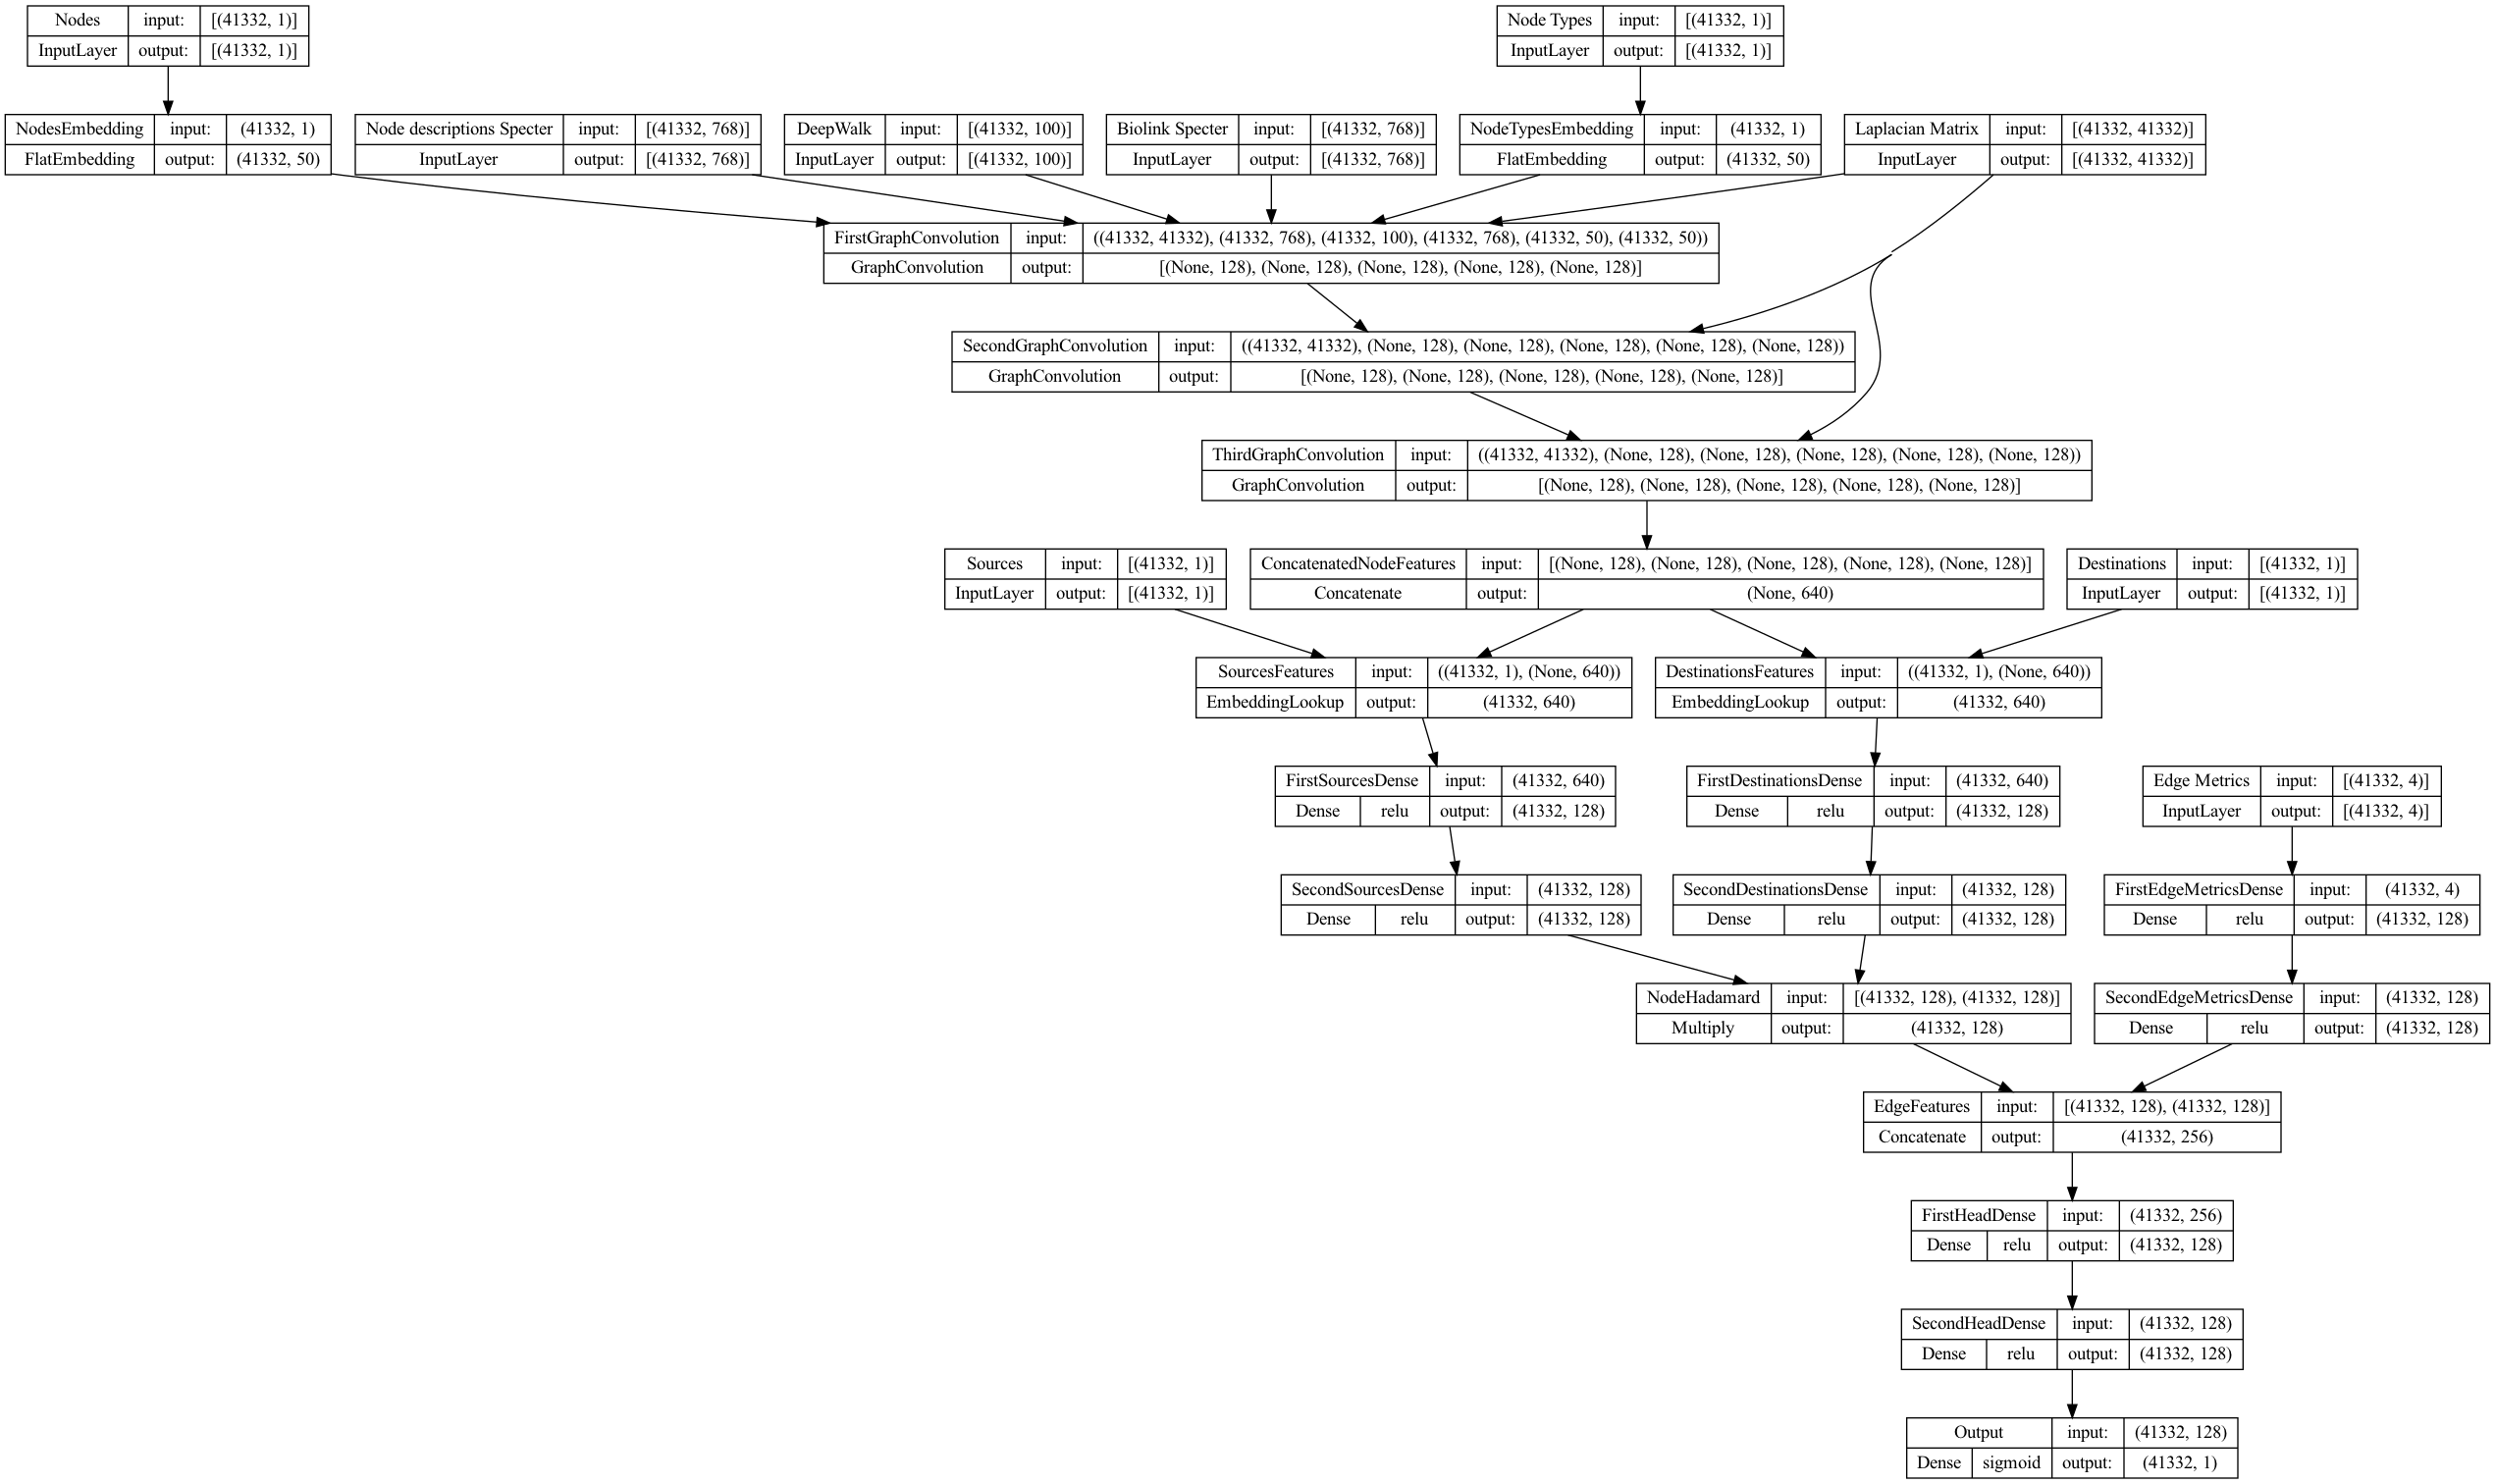

In [8]:
model.plot()

### Running the predictions

GRAPE offers many options for running predictions on subgraphs of interest. The available methods include options for predicting on bipartite graphs and clique graphs, as well as methods for obtaining probability estimates for the predictions. 

These methods provide a range of options for running predictions on different types of subgraphs using different types of input. Users can choose the appropriate method depending on the specific needs of their application.

In [9]:
# There are many ways to run predictions!

[
    method
    for method in dir(model)
    if method.startswith("predict")
]

['predict',
 'predict_bipartite_graph_from_edge_node_ids',
 'predict_bipartite_graph_from_edge_node_names',
 'predict_bipartite_graph_from_edge_node_prefixes',
 'predict_bipartite_graph_from_edge_node_types',
 'predict_clique_graph_from_node_ids',
 'predict_clique_graph_from_node_names',
 'predict_clique_graph_from_node_prefixes',
 'predict_clique_graph_from_node_type_names',
 'predict_proba',
 'predict_proba_bipartite_graph_from_edge_node_ids',
 'predict_proba_bipartite_graph_from_edge_node_names',
 'predict_proba_bipartite_graph_from_edge_node_prefixes',
 'predict_proba_bipartite_graph_from_edge_node_types',
 'predict_proba_clique_graph_from_node_ids',
 'predict_proba_clique_graph_from_node_names',
 'predict_proba_clique_graph_from_node_prefixes',
 'predict_proba_clique_graph_from_node_type_names']

One way to run predictions using the GRAPE tool is to predict all edges within a clique defined by node type names. This can be done using the `predict_proba_clique_graph_from_node_type_names` method, as shown in the following code snippet:

In [10]:
predictions = model.predict_proba_clique_graph_from_node_type_names(
    node_type_names=["biolink:SequenceFeature"],
    graph=graph_main_component,
    support=graph_main_component,
    node_features=[node_descriptions_embedding, deepwalk_embedding],
    node_type_features=node_type_features,
    return_predictions_dataframe=True,
    return_node_names=True
)

predictions

/Users/lucacappelletti/opt/miniconda3/lib/python3.7/site-packages/embiggen/utils/abstract_gcn.py:83: UserWarning: The GCN model does not currently support convolutions on a multigraph. We are dropping the parallel edges before computing the adjacency matrix.
  warnings.warn(message)


,predictions,sources,destinations
0,0.999650,SO:0000946,SO:0000946
1,0.828019,SO:0000946,SO:0000831
2,0.854654,SO:0000946,SO:0000460
3,0.670446,SO:0000946,SO:0000453
4,0.078018,SO:0000946,SO:0000483
...,...,...,...
4895,0.029169,SO:0001217,SO:0001260
4896,0.723603,SO:0001217,SO:0001263
4897,0.003163,SO:0001217,SO:1000183
4898,0.014338,SO:0001217,SO:1000182


The `predict_proba_clique_graph_from_node_type_names` method takes several arguments, including the names of the node types to use to define the clique, the main graph and support graph, node and node type features, and options for returning the predictions as a dataframe and for returning node names. The method returns a dataframe containing the predicted probabilities for each edge in the clique, along with the names of the source and destination nodes for each edge.

The following section describes how to obtain the mask of edges that are already known in a given graph. This is done by using the `has_edge_from_node_names` method from the main graph to check whether each edge in the predictions dataframe exists in the graph. The known edges are then stored in a numpy array.

In [11]:
import numpy as np

known = np.array([
    graph_main_component.has_edge_from_node_names(src,  dst)
    for src, dst in zip(
        predictions.sources,
        predictions.destinations
    )
])

The following section shows how to better understand the predictions by comparing the predicted edges to the known edges in the graph. This is done by plotting the predicted probabilities for known and unknown edges on a histogram and comparing the distributions. This allows us to see how well the model is able to predict known edges and how well it is able to identify unknown edges that are likely to exist in the graph. The resulting histogram can provide insight into the accuracy and reliability of the model's predictions.

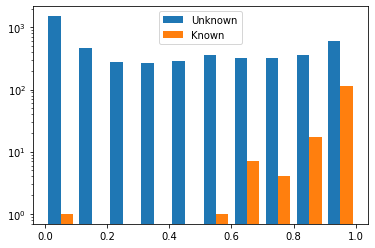

In [12]:
import matplotlib.pyplot as plt

plt.hist(
    [predictions.predictions[~known],
    predictions.predictions[known],],
    label=["Unknown", "Known"],
    log=True
)
plt.legend()

## Conclusions

### What we have seen in this tutorial
In this tutorial, we have built a multi-modal GCN model for edge prediction on the MONDO disease ontology. We have shown how to retrieve and preprocess the graph, and how to use a variety of input features, including BM25-weighted BERT-based embedding of node descriptions and node types, as well as a DeepWalk topological embedding. The model has been trained on a subset of the graph and we have used it to make predictions about the edges in the graph.

### What we have NOT seen, and we will see in the future
We have seen that the model performs well on the known edges in the graph, but we have not yet evaluated its performance on unseen data. In the next tutorial, we will use GRAPE's edge prediction evaluation pipeline to assess the performance of our model in a more rigorous and systematic way. This will allow us to determine whether the model is able to generalize to unseen data and is not just overfitting on the input data. We will also learn how to use other metrics, such as precision, recall, and F1 score, to evaluate the performance of the model. This will give us a better understanding of the strengths and weaknesses of the model and will help us to improve its performance.